## Crossentropy Method

В этой пункте мы посмотрим на то, как решить задачи RL с помощью метода crossentropy.

Рассмотрим пример с задачей Taxi [Dietterich, 2000](https://arxiv.org/pdf/cs/9905014.pdf).

### Кросс-Энтропийный Метод (CEM) для Обучения с Подкреплением
**Идея:**

Кросс-энтропийный метод (CEM) представляет собой подход к обучению с подкреплением, цель которого — найти оптимальную стратегию действий агента через итеративное улучшение оценок параметров. Метод основан на выборке и оценке эффективности стратегий, с последующим фокусом на наиболее успешных из них.

### Шаги Метода:
**Генерация Пробных Стратегий**
Генерируются стратегии на основе начального распределения параметров.

**Оценка Стратегий**
Производительность каждой стратегии оценивается по награде, полученной агентом.

**Отбор и Обновление**
Выбираются наилучшие стратегии.
Обновляется распределение параметров для генерации новых стратегий.

**Итерация**
Процесс повторяется с обновленными параметрами до достижения критерия остановки.

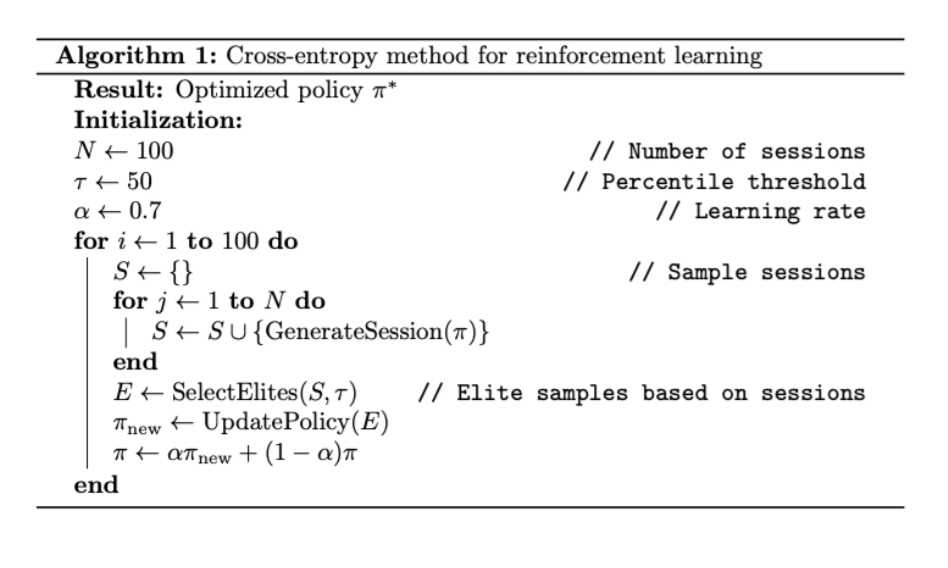

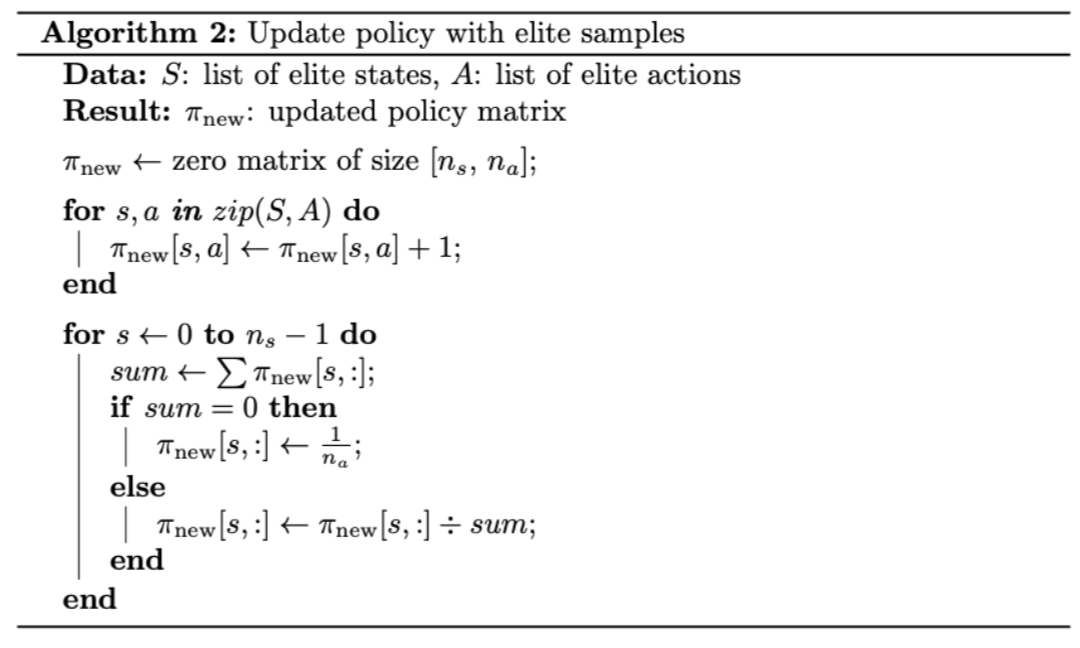

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [ ]:
import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

def show_video(folder="./video"):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

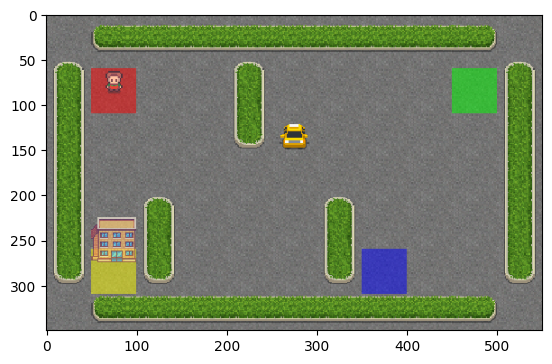

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

In [ ]:
n_states  = env.observation_space.n
n_actions = env.action_space.n

print(f"состояний: {n_states} действий: {n_actions}")

состояний: 500 действий: 6


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


В этот раз нашей стратегией будет вероятностной распределение.

$\pi(s,a) = P(a|s)$

Для задачи такси мы можем использовать таблицу:

policy[s,a] = P(выбрать действие a | в состоянии s)

Создадим "равномерную" стратегию в виде двумерного массива с
равномерным распределением по действиям и сгенерируем игровую сессию с такой стратегией

In [ ]:
def initialize_policy(n_states, n_actions):
    """<codehere>"""
    policy = np.full((n_states, n_actions), 1. / n_actions)
    """</codehere>"""
    return policy

policy = initialize_policy(n_states, n_actions)

In [ ]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

### Генерация сессий взаимодейтсвия со средой.

Мы будем запоминать все состояния, действия и вознаграждения за эпизод.

In [ ]:
policy[0][0] = 2./n_actions
policy[0][1] = 0
policy[0]

array([0.33333333, 0.        , 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [ ]:
np.random.default_rng().choice(6, p=policy[0])

2

In [ ]:
import numpy as np

arr = np.array([1,2,3,4,5])
action_mask = np.full(5,1)
action_mask[3] = 0

masked = arr * action_mask
masked / masked.sum()

array([0.09090909, 0.18181818, 0.27272727, 0.        , 0.45454545])

In [ ]:
def generate_session(env, policy, t_max=10**4):
    """
    Игра идет до конца эпизода или до t_max шагов в окружении.
    :param policy: [n_states,n_actions]
    :returns: states - список состояний, actions - список действий, session_return - итоговая отдача
    """
    states, actions = [], []
    session_return = 0.

    s, info = env.reset()
    action_mask = np.full(n_actions,1)
    for t in range(t_max):
        # Подсказка: вы можете использовать `np.random.default_rng().choice`
        # для сэмплирования
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html
        # a =
        """<codehere>"""
        prob = policy[s] * action_mask
        prob = prob/  prob.sum()
        a = np.random.default_rng().choice(n_actions, p=prob)
        """</codehere>"""
        new_s, r, terminated, truncated, info = env.step(a)

        action_mask = info['action_mask']
        #{'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)})

        # Записываем информацию, который мы получили от среды.
        states.append(s)
        actions.append(a)
        session_return += r

        s = new_s
        if terminated:
            break

    return states, actions, session_return

In [ ]:
env.step(0)

(242,
 -1,
 False,
 False,
 {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)})

In [ ]:
s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert isinstance(r, float)

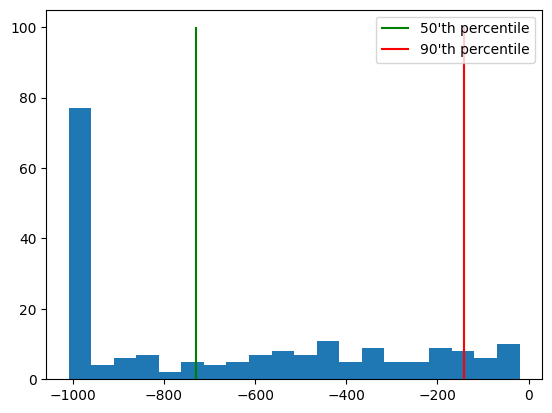

In [ ]:
# посмотрим на изначальное распределение вознаграждения
import matplotlib.pyplot as plt
%matplotlib inline

sample_returns = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_returns, bins=20)
plt.vlines([np.percentile(sample_returns, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_returns, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Реализация метода crossentropy  

Наша задача - выделить лучшие действия и состояния, т.е. такие, при которых было лучшая отдача:

In [ ]:
def select_elites(states_batch, actions_batch,
                  returns_batch, percentile=50):
    """
    Выбирает состояния и действия с заданным перцентилем (rewards >= percentile)
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of session returns, returns_batch[session_i]

    :returns: elite_states, elite_actions - одномерные
    списки состояния и действия, выбранных сессий
    """
    # нужно найти порог вознаграждения по процентилю
    # reward_threshold =
    """<codehere>"""
    return_threshold = np.percentile(returns_batch, percentile)
    """</codehere>"""


    # в соответствии с найденным порогом - заполнить списки
    # elite_states и elite_actions, нужными состояниями и действиями
    elite_states = []
    elite_actions = []
    """<codehere>"""
    for index, session_return in enumerate(returns_batch):
        if session_return >= return_threshold:
            elite_states += states_batch[index]
            elite_actions += actions_batch[index]
    """</codehere>"""

    return elite_states, elite_actions

In [ ]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
returns_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, returns_batch, percentile=0)
test_result_30 = select_elites(states_batch, actions_batch, returns_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, returns_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, returns_batch, percentile=100)

assert np.all(
    test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) \
       and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]), \
    "Для процентиля 0 необходимо выбрать все состояния " \
    "и действия в хронологическом порядке"

assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1])\
   and np.all(test_result_30[1] == [3, 2, 0, 1, 3, 3]), \
    "Для процентиля 30 необходимо выбрать " \
    "состояния/действия из [3:]"
assert np.all(test_result_90[0] == [3, 1]) and \
       np.all(test_result_90[1] == [3, 3]), \
    "Для процентиля 90 необходимо выбрать состояния " \
    "действия одной игры"
assert np.all(test_result_100[0] == [3, 1]) and \
       np.all(test_result_100[1] == [3, 3]), \
    "Проверьте использование знаков: >=,  >. " \
    "Также проверьте расчет процентиля"
print("Тесты пройдены!")


Тесты пройдены!


Теперь мы хотим написать обновляющуюся стратегию:

In [ ]:
def update_policy(elite_states,elite_actions):
    """
    Новой стратегией будет:
    policy[s_i,a_i] ~ #[вхождения  si/ai в лучшие states/actions]

    Не забудьте про нормализацию состояний.
    Если какое-то состояние не было посещено,
    то используйте равномерное распределение 1./n_actions

    :param elite_states:  список состояний
    :param elite_actions: список действий
    """
    new_policy = np.zeros([n_states,n_actions])

    # обновляем стратегию - нормируем новые частоты
    # действий и не забываем про непосещенные состояния
    """<codehere>"""
    for state, action in zip(elite_states, elite_actions):
        new_policy[state][action] += 1

    for state in range(len(new_policy)):
        s = np.sum(new_policy[state])
        if s == 0:
            new_policy[state, :] = 1. / n_actions # равномерно выбираем действия
        else:
            new_policy[state, :] /= s #увеличиваем вероятность просемплировать те действия, которые приносили успех
    """</codehere>"""
    return new_policy

In [ ]:
elite_states, elite_actions = (
    [1, 2, 3, 4, 2, 0, 2, 3, 1],
    [0, 2, 4, 3, 2, 0, 1, 3, 3])

new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(
    new_policy).all(), "Стратегия не должна содержать " \
                       "NaNs или +-inf. Проверьте " \
                       "деление на ноль. "
assert np.all(
    new_policy >= 0), "Стратегия не должна содержать " \
                      "отрицательных вероятностей "
assert np.allclose(new_policy.sum(axis=-1),
                   1), "Суммарная\ вероятность действий"\
                       "для состояния должна равняться 1"
reference_answer = np.array([
    [1., 0., 0., 0., 0.],
    [0.5, 0., 0., 0.5, 0.],
    [0., 0.33333333, 0.66666667, 0., 0.],
    [0., 0., 0., 0.5, 0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Тесты пройдены!")

Тесты пройдены!


<>:15: DeprecationWarning: invalid escape sequence '\ '


### Цикл обучения

Визуализириуем наш процесс обучения и также будем измерять распределение получаемых за сессию отдач

In [ ]:
from IPython.display import clear_output

def show_progress(returns_batch, log, percentile, return_range=[-990, +10]):
    """
    Удобная функция, для визуализации результатов.
    """

    mean_return = np.mean(returns_batch)
    threshold = np.percentile(returns_batch, percentile)
    log.append([mean_return, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean returns')
    plt.plot(list(zip(*log))[1], label='Return thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(returns_batch, range=return_range)
    plt.vlines([np.percentile(returns_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean return = %.3f, threshold=%.3f" % (mean_return, threshold))
    plt.show()

In [ ]:
# инициализируем стратегию
policy = initialize_policy(n_states, n_actions)

mean return = -27.650, threshold=4.000


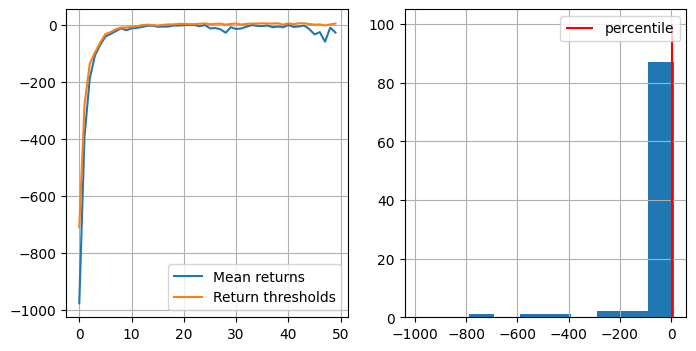

In [ ]:
from tqdm.notebook import tqdm
n_sessions = 100  # количество сессий для сэмплирования
percentile = 50  # перцентиль
learning_rate = 0.5 # то как быстро стратегия будет обновляться


log = []



for i in tqdm(range(50)):
    # генерируем n_sessions сессий
    # sessions = []
    """<codehere>"""
    sessions = [generate_session(env, policy) for _ in range(n_sessions)]
    """</codehere>"""

    states_batch, actions_batch, returns_batch = zip(*sessions)
    # отбираем лучшие действия и состояния ###
    # elite_states, elite_actions =
    """<codehere>"""
    elite_states, elite_actions = select_elites(
        states_batch, actions_batch, returns_batch, percentile
    )
    """</codehere>"""

    # обновляем стратегию
    # new_policy =
    """<codehere>"""
    new_policy = update_policy(elite_states, elite_actions)
    """</codehere>"""

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # выводим график с результатами
    show_progress(returns_batch, log, percentile)

### Посмотрим на результаты
Задача такси быстро сходится, начиная с отдачи -1000 к почти оптимальному значению, а потом опять падает до -50/-100. Это вызвано случайностью в самом окружении $-$ случайное начальное состояние пассажира и такси, в начале каждого эпизода.

В случае если алгоритм CEM не сможет научиться тому, как решить задачу из какого-то стартового положения, он просто отбросит этот эпизод, т.к. не будет сессий, которые переведут этот эпизод в топ лучших.

Для решения этой проблемы можно уменьшить threshold (порог лучших состояний) или изменить способ оценки стратегии, используя новую стратегию, полученную из каждого начального состояния и действия (теоретически правильный способ).

In [ ]:
final_session = generate_session(env, policy)

In [ ]:
from gymnasium.wrappers.record_video import RecordVideo

# создаем окружение с ограничением на число шагов в среде
#env = gym.make("Taxi", render_mode="rgb_array", max_episode_steps=250)
# добавляем визуализацию
video_index = "./video3"
env_video = RecordVideo(env, video_index)

# проводим инициализацию и запоминаем начальное состояние
s, _ = env_video.reset()
done = False
steps_counter = 1000
while not done and steps_counter>0:
    a = np.random.default_rng().choice(n_actions, p=policy[s])
    s, r, terminated, truncated, info = env_video.step(a)
    steps_counter += -1
    #s, r, done, _, _ = env.step(env.action_space.sample())

env_video.close()
show_video(video_index)

Moviepy - Building video /content/video3/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video3/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video3/rl-video-episode-0.mp4
